<a href="https://colab.research.google.com/github/jackyman1997/LSTM/blob/main/LSTM_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
pip install torchmetrics

In [36]:
import pandas as pd
import numpy as np
import torch
import torchmetrics
import typing
from matplotlib import pyplot as plt
%matplotlib inline
from math import isclose

In [37]:
from os import listdir
from pandas import DataFrame, read_csv
from pandas.core.series import Series
from numpy import ndarray
import typing


def get_csv_data(folder_path: str) -> typing.List[DataFrame]:
    data = []
    files_paths = listdir(folder_path)
    for filename in files_paths:
        filepath = folder_path + "/" + filename
        data.append(read_csv(filepath))
    return data


def get_csv_data_colab(folder_path: str) -> typing.List[DataFrame]:
    data = []
    files = listdir(folder_path)
    for file in files:
        if file.endswith('.csv'):
            df = read_csv(folder_path+file)
            data.append(df)
    return data


def get_data_local():
    return NotImplementedError


def get_data_S3():
    return NotImplementedError


def get_data_RDS():
    return NotImplementedError


def diff_seq(
    seq: typing.Union[list, ndarray, Series],
    interval: int = 1,
    same_length: bool = False
) -> Series:
    output = [seq[i] - seq[i - interval] for i in range(interval, len(seq))]
    if same_length:
        for i in range(interval):
            output.insert(0, 0)
    return Series(output)


In [38]:
# get data
data = get_csv_data_colab(folder_path="raw_data/")

In [39]:
difference = [diff_seq(full_seq["C"], 1, same_length=True) for i, full_seq in enumerate(data)]

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


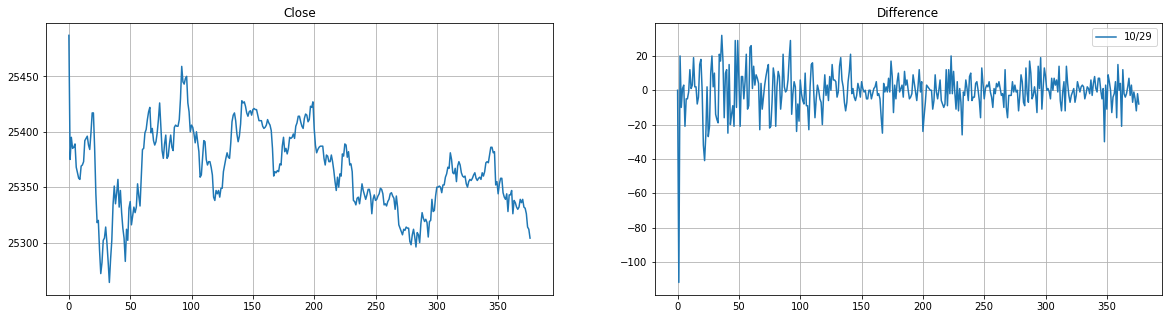

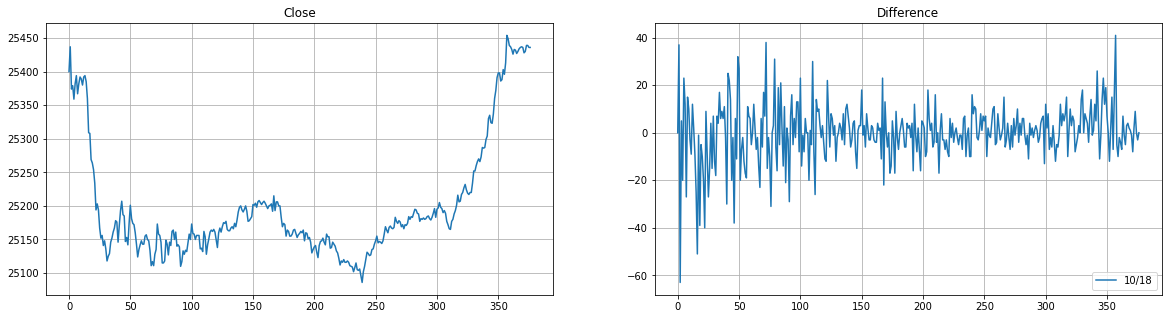

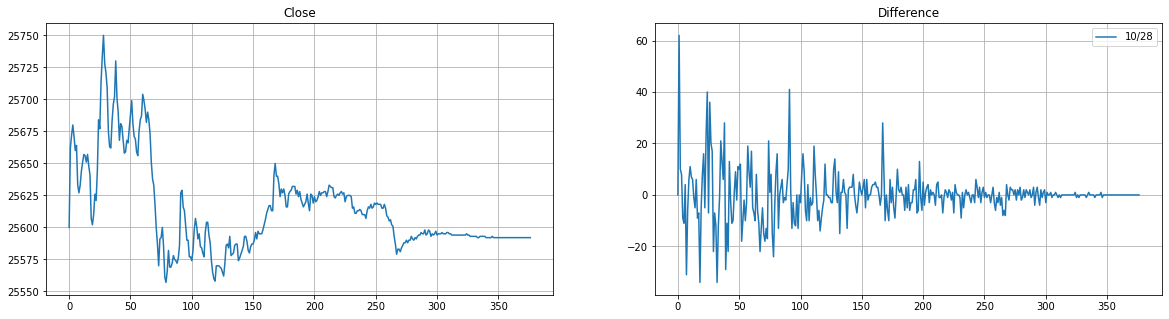

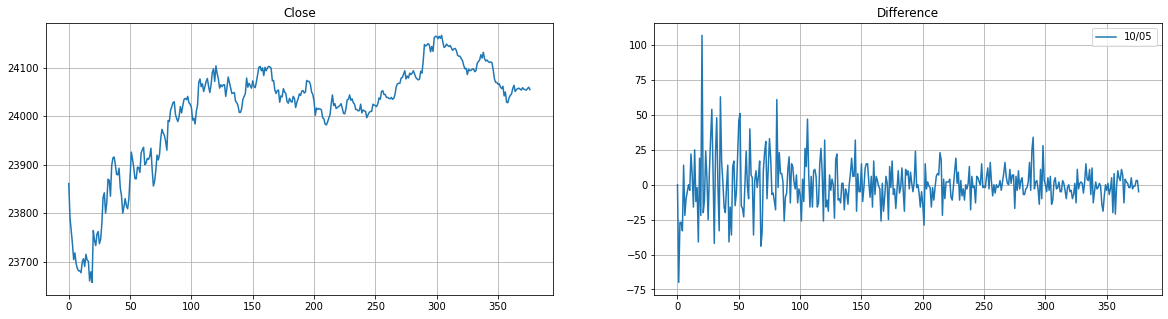

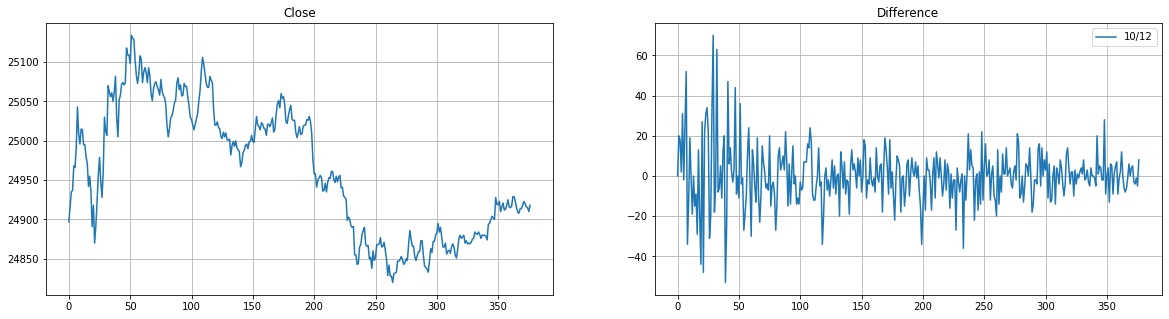

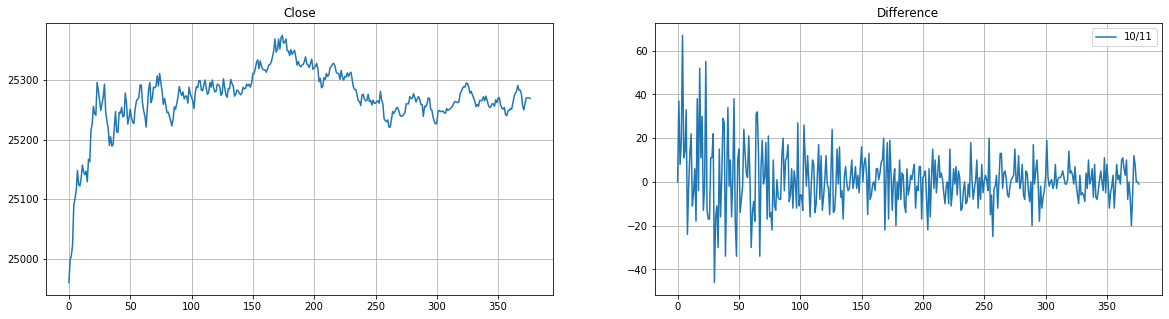

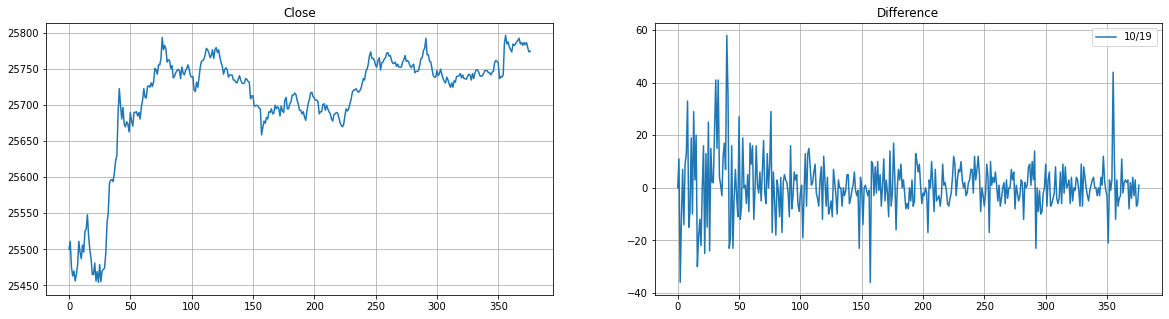

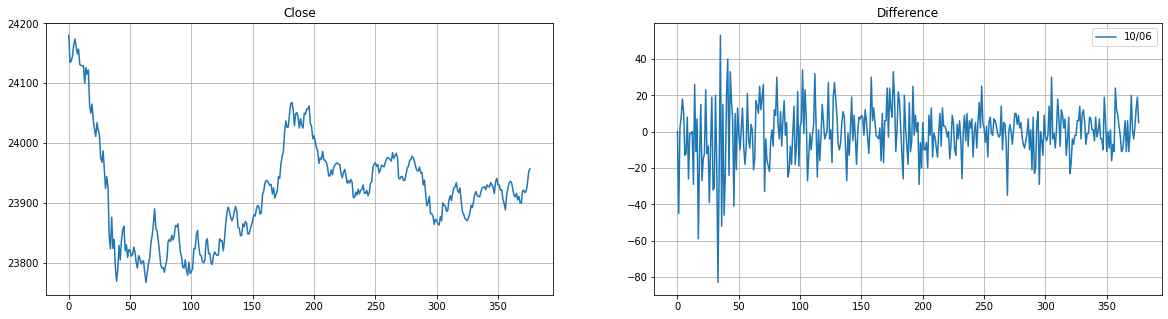

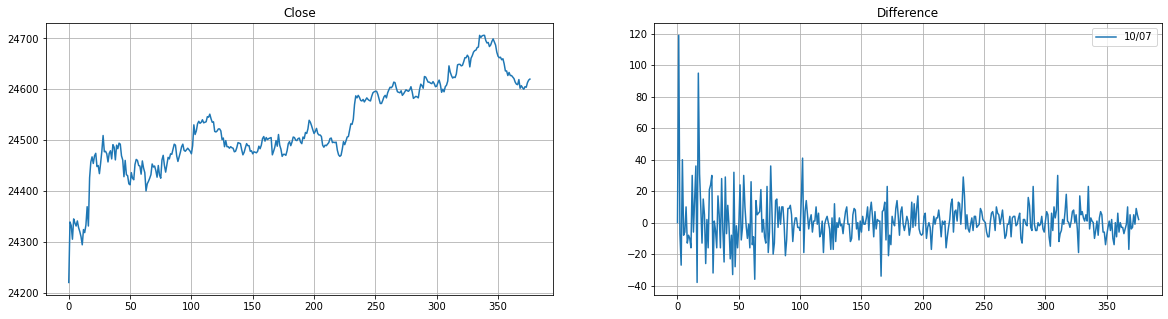

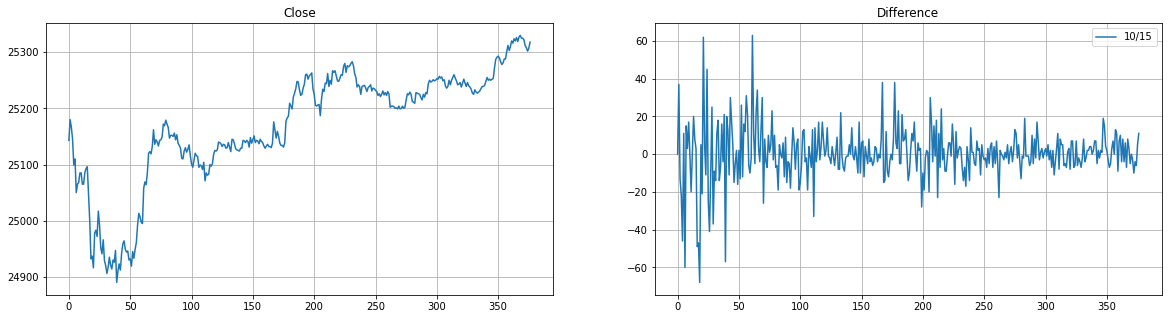

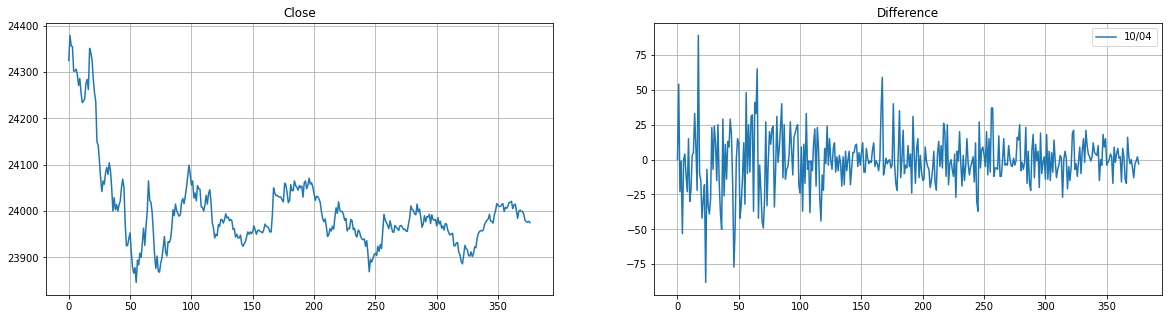

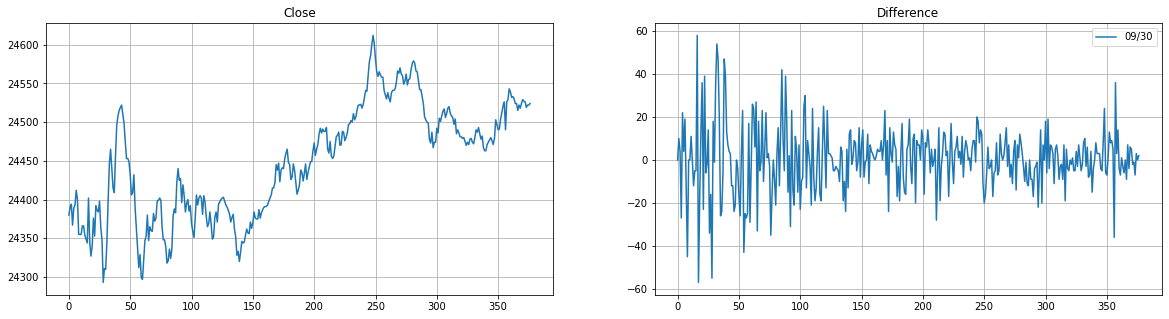

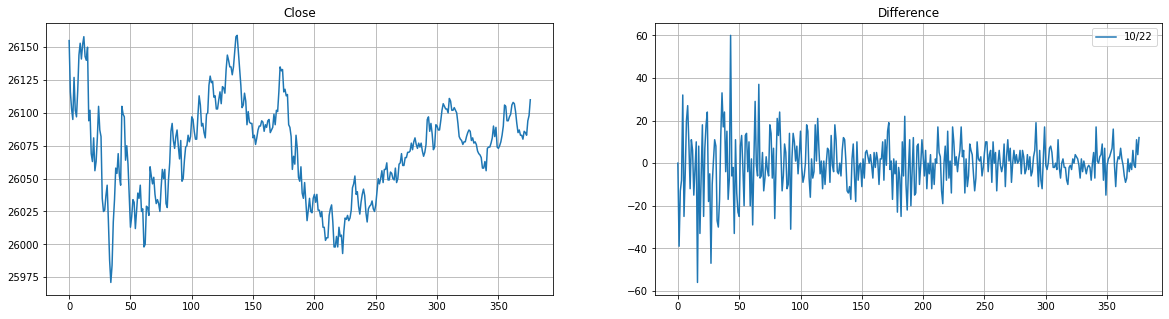

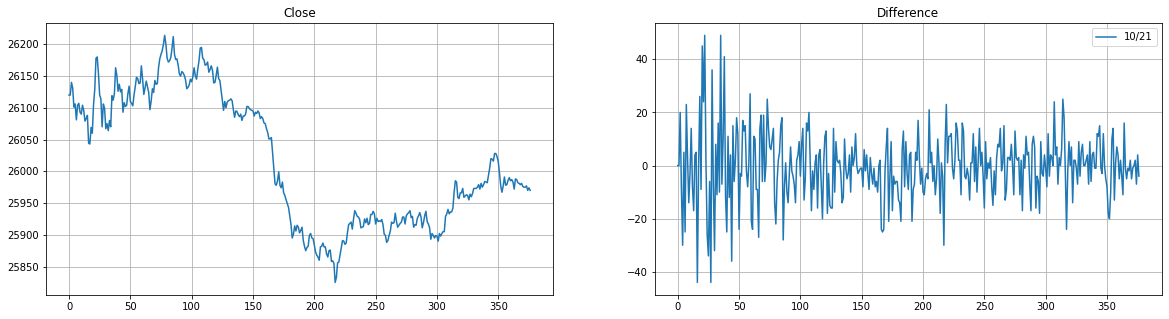

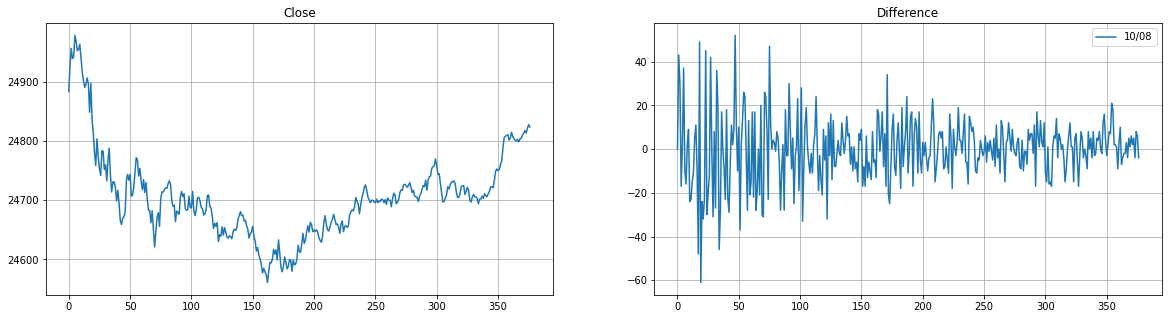

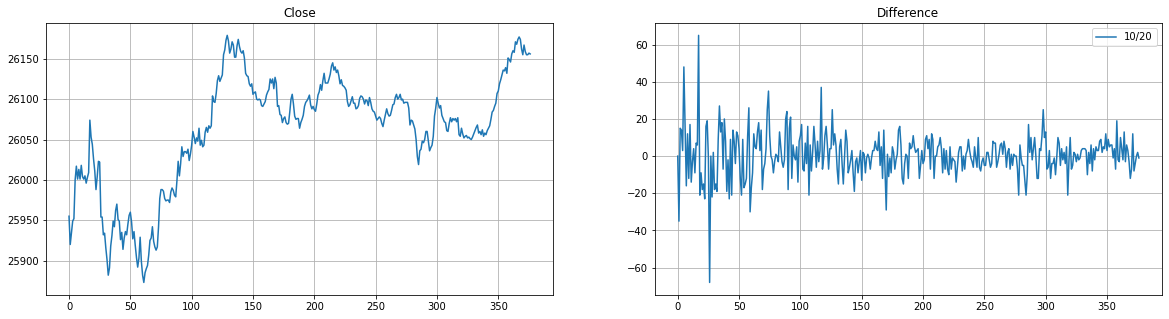

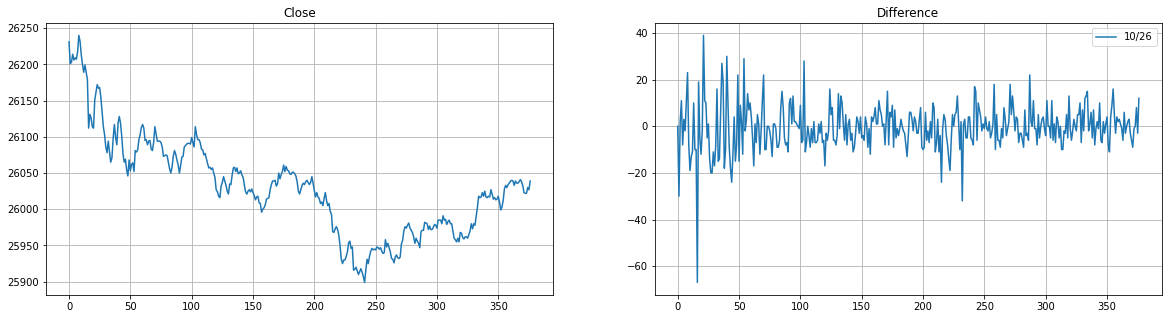

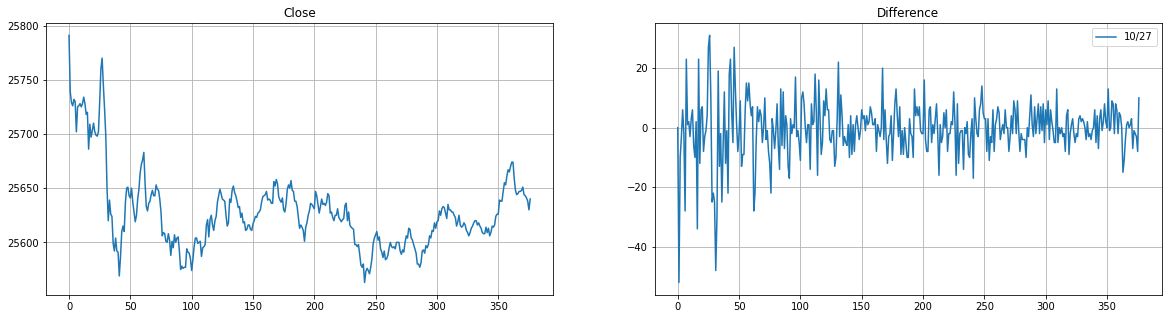

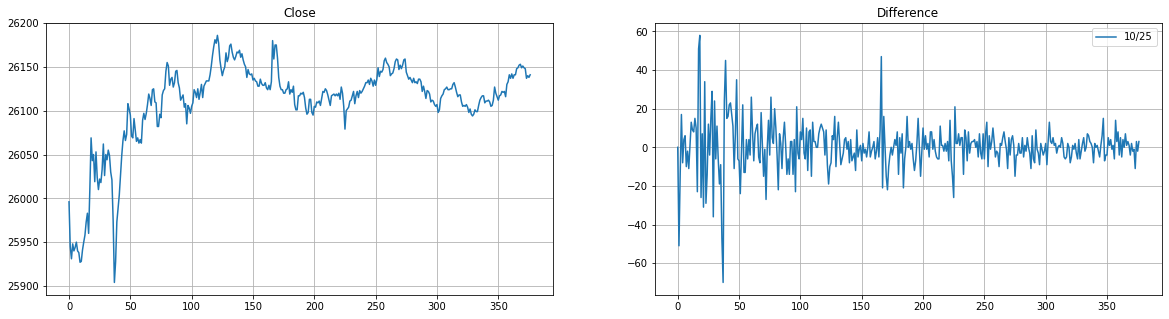

In [40]:
for i, seq in enumerate(difference): 
    fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
    ax1.plot(data[i]["C"], label=f"{data[i]['Date'][0]}")
    ax1.grid(True)
    ax1.set_title("Close")
    ax2.legend()
    ax2.plot(seq, label=f"{data[i]['Date'][0]}")
    ax2.grid(True)
    ax2.set_title("Difference")
    ax2.legend()
    fig.show()

In [53]:
# dataloader
class StockData(torch.utils.data.Dataset):

    def __init__(self, features, targets):
        self.targets = torch.tensor(targets)  # cast targets to tensor
        self.features = torch.tensor(features)  # calculates total count of unique targets

    def __getitem__(self, index):
        return self.features[index], self.targets[index]

    def __len__(self):
        return len(self.targets)

    def split(self, *split_ratio): 
        '''
        returns torch random split object (this instance) \n
        if numbers > 1 are given: check if sum == len, then pass to torch.utils.data.random_split \n
        if numbers < 1 are given: then the sum must == 1, then compute the length og each portion \n
        '''
        summed = sum(split_ratio)
        if not isclose(summed, 1.0):  # or and abs( 1-sum(split_ratio) ) > 1e-15
            if summed != len(self): # check if the sum == len
                raise ValueError(
                    f"sum of splitted lengths does not match the data length\ninstead of the total of {len(self)} or total ratio of 1, {split_ratio} -> {sum(split_ratio)} were given")  
            self.sizes = split_ratio
        else:  # if sum == 1
            self.sizes = [ int( ratio*len(self) ) for ratio in split_ratio[:-1] ]  # leave one out, the left will be the last term, so that dun need to deal with the rounding problem 
            self.sizes.append(len(self) - sum(self.sizes))  # add the rest instead of the length*ratio, for the last term
        return torch.utils.data.random_split(self, self.sizes)

    def dataloader(self, *args, **kwargs: typing.Any):
        return torch.utils.data.DataLoader(self, *args, **kwargs)

In [66]:
class Encoder(torch.nn.Module):
    def __init__(
        self,
        seq_length,
        n_features,
        output_length,
        hidden_size,
        num_layers: int = 1,
        batch_first: bool = False,
        dropout: float = 0,
        bidirectional: bool = False,
        add_linear: bool = False
    ):
        super().__init__()
        self.seq_length = seq_length
        self.n_features = n_features
        self.output_length = output_length
        self.n_direction = 2 if bidirectional else 1
        self.add_linear = add_linear
        self.LSTM = torch.nn.LSTM(
            input_size=n_features,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=batch_first,
            dropout=dropout,
            bidirectional=bidirectional
        )
        if add_linear:
            self.linear = torch.nn.Linear(
                self.LSTM.hidden_size * self.n_direction,
                self.output_length
            )

    def forward(self, seq):
        # for this case (BATCH_FIRST),
        # seq dim is (batch, seq_length, n_features), check using torch.randn(bitch_size, seq_length, n_features)
        # output is seq, (h_n, c_n) having dim as:
        # (batch, seq_length, n_features*self.D)
        # (batch, self.D*num_layers, hidden_size) since proj_size is set 0 here otherwise it s proj_size
        # (batch, self.D*num_layers, hidden_size)
        if self.add_linear:
            _, (h_n, _) = self.LSTM(X)
            # reshape the h_n (last output) to (num_layer, n_direction, batch=-1 (-1 means all), hidden_size)
            # get the last one, which is the last layer from the h_n
            # then get rid of the num_layer, as we chose the last layer, hence squeeze(dim=0)
            h_n = h_n.reshape(
                self.LSTM.num_layers,
                self.n_direction,
                -1,
                self.LSTM.hidden_size
            )[-1].squeeze(dim=0)
            # if LSTM is bidirectional, concat the 2 direction outputs (last layer of h_n)
            # from above, h_n now has the shape of (n_direction, batch, hidden_size)
            # so h_n[0] is 1 direction, h_n[1] is the other, size of (batch, hidden_size)
            # concat about the hidden_size can keep the batch size no changed
            # hence output the size of (batch, n_direction * hidden_size)
            if self.LSTM.bidirectional: 
                h_n = torch.cat((h_n[0], h_n[1]), dim=-1)
            else:
                h_n = h_n.squeeze(dim=0)
            return self.linear(h_n)
        else: 
            output, (h_n, c_n) = self.LSTM(X)
            return output, (h_n, c_n)


In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_data = np.array([])
target_data = np.array([])
n_features = 1  # this fixed for now
for i, (X, y) in enumerate(zip(data[:-1], data[1:])):
    X, y = X[["C"]].to_numpy(dtype=np.float32), y[["C"]].to_numpy(dtype=np.float32)
    input_data = np.append(input_data, X).reshape(i+1, len(X), n_features)
    target_data = np.append(target_data, y).reshape(i+1, len(y), n_features)

ready_data = StockData(features=input_data, targets=target_data)
train, test, val = ready_data.split(*[0.7, 0.2, 0.1])

len(train), len(val), len(test)

(12, 3, 3)

In [68]:
params = {
    'seq_length': 377,
    'n_features': 1,
    'output_length': 377,
    'hidden_size': 3,
    'num_layers': 3,
    'batch_first': True,
    'dropout': 0.5,
    'bidirectional': False,
    'add_linear': True
}
rnn = Encoder(**params).to(device)

epoch 0 train: 625733760.0
epoch 0 test: 626714560.0


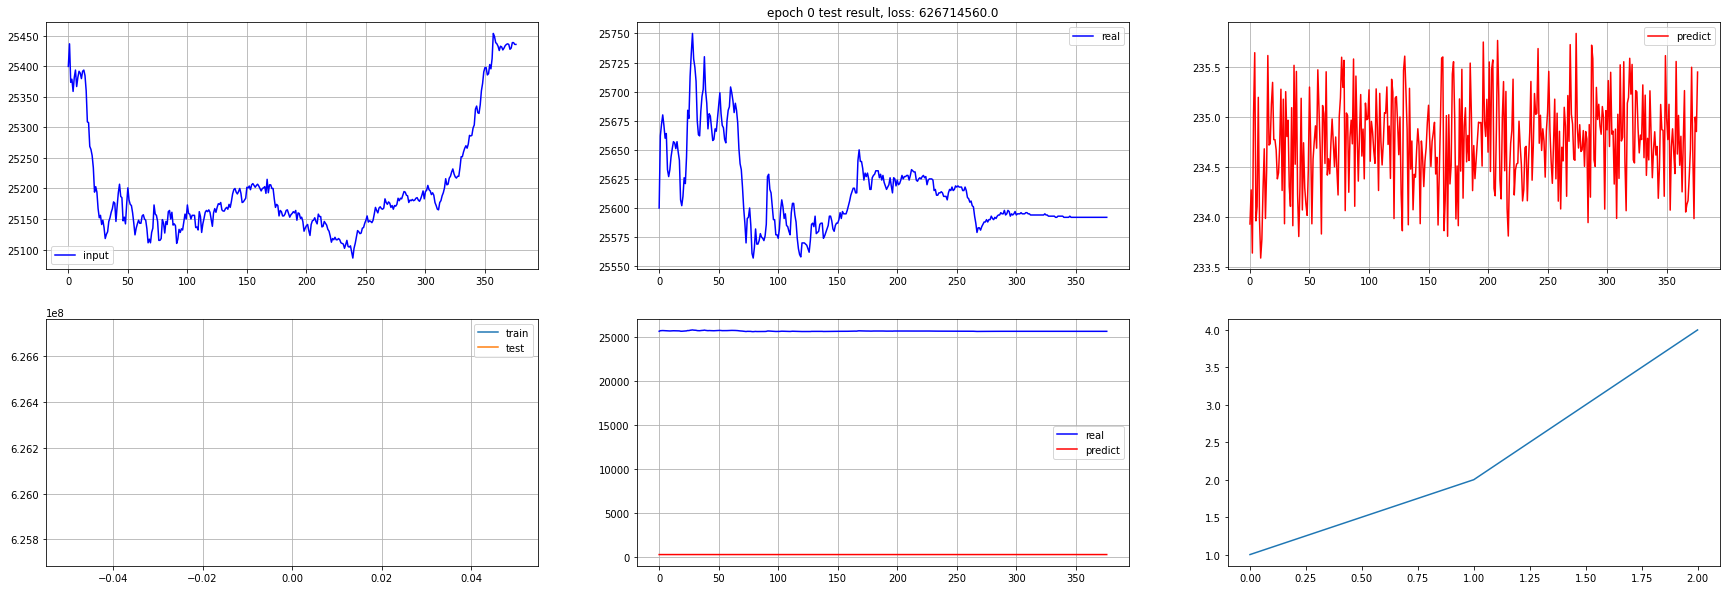

epoch 75 train: 311764832.0
epoch 75 test: 311229792.0


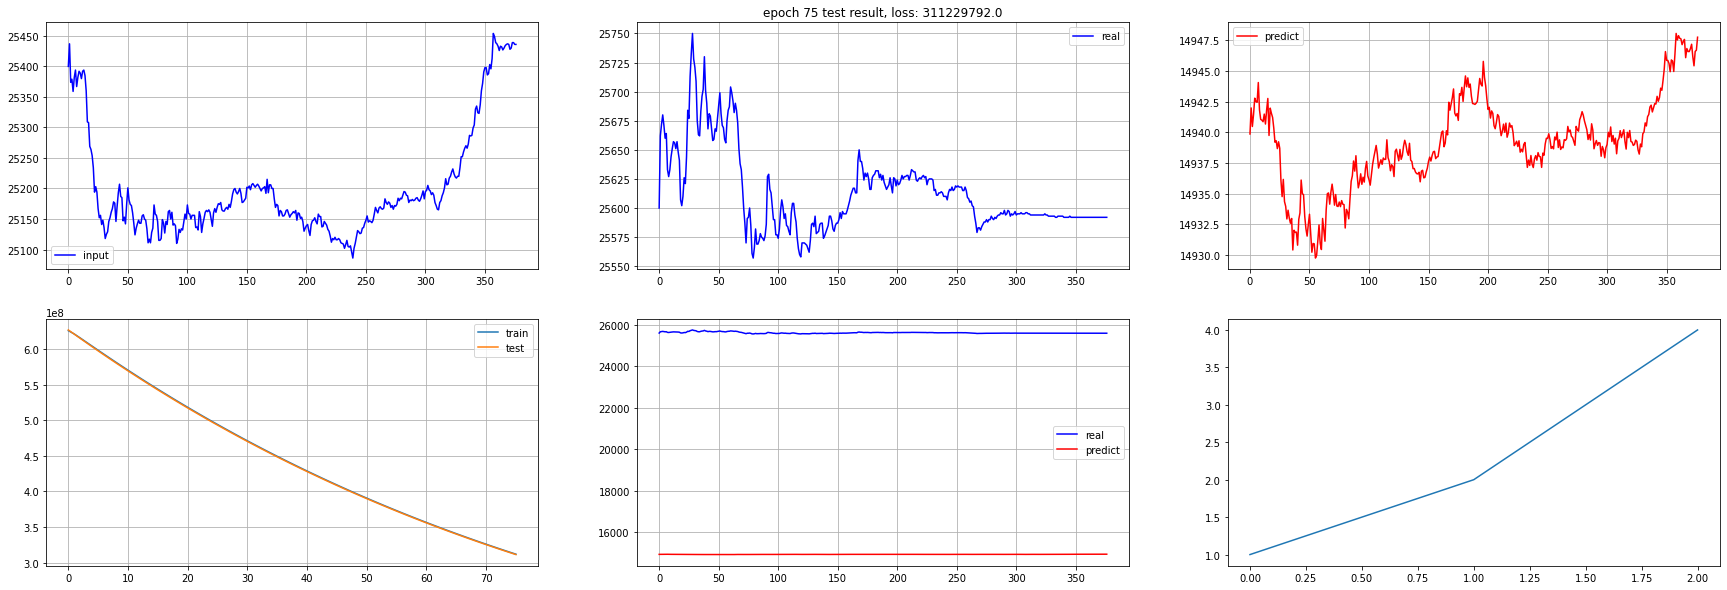

epoch 150 train: 176156992.0
epoch 150 test: 175933408.0


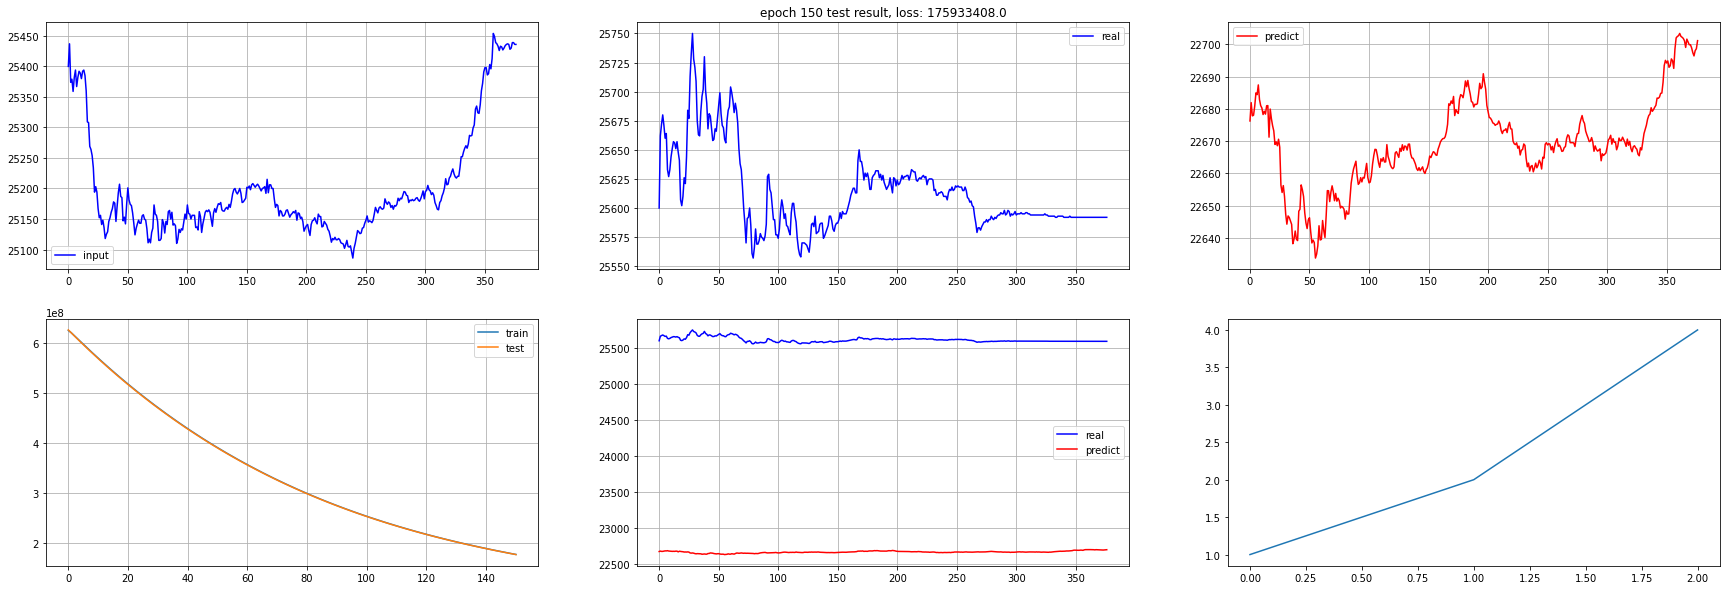

epoch 225 train: 118323768.0
epoch 225 test: 118219440.0


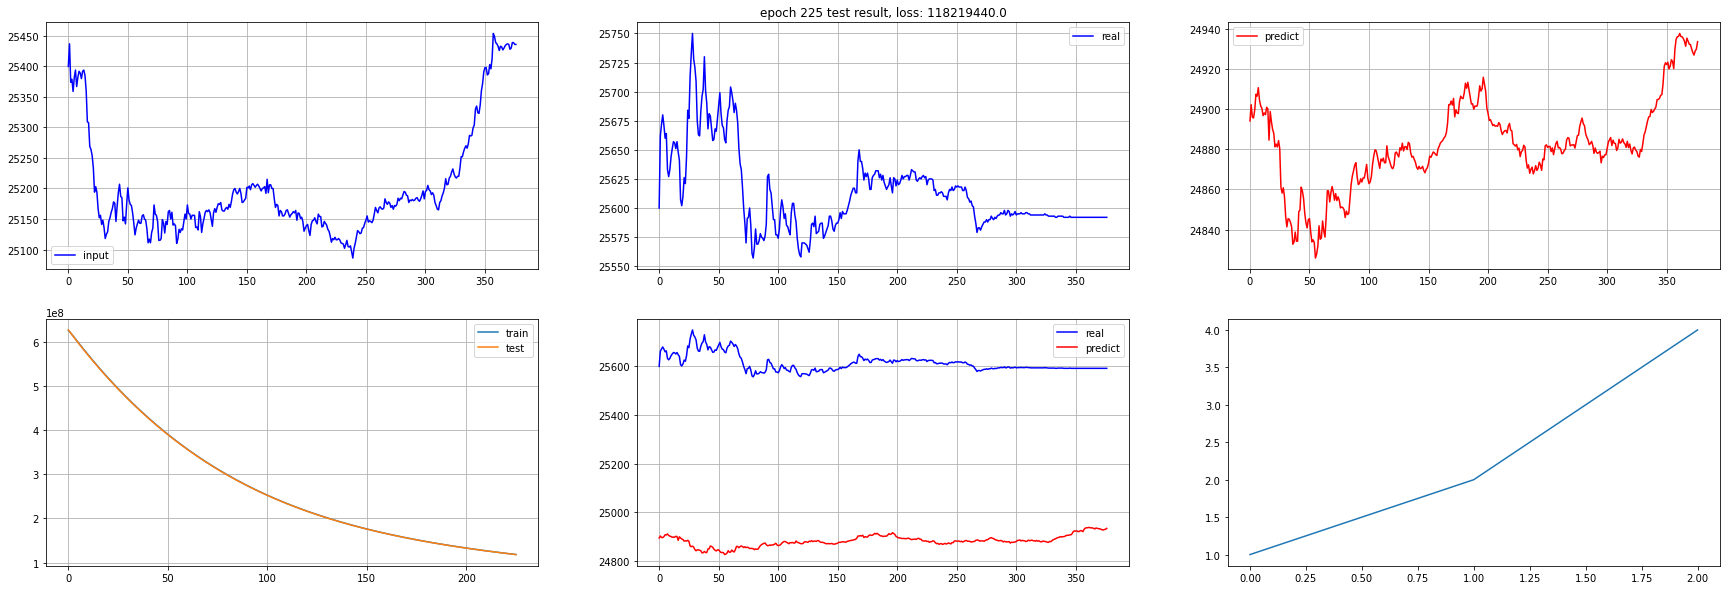

epoch 300 train: 88947352.0
epoch 300 test: 88888432.0


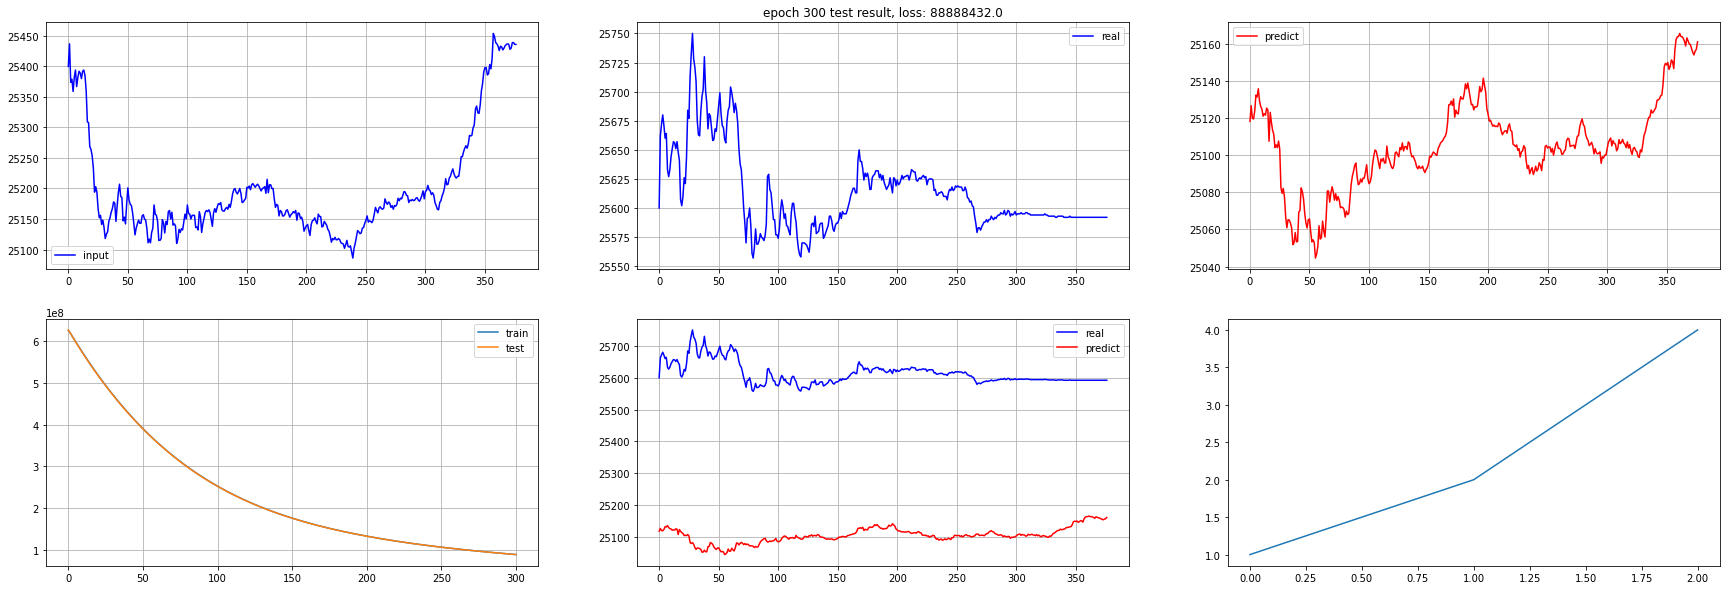

epoch 375 train: 71294152.0
epoch 375 test: 71256368.0


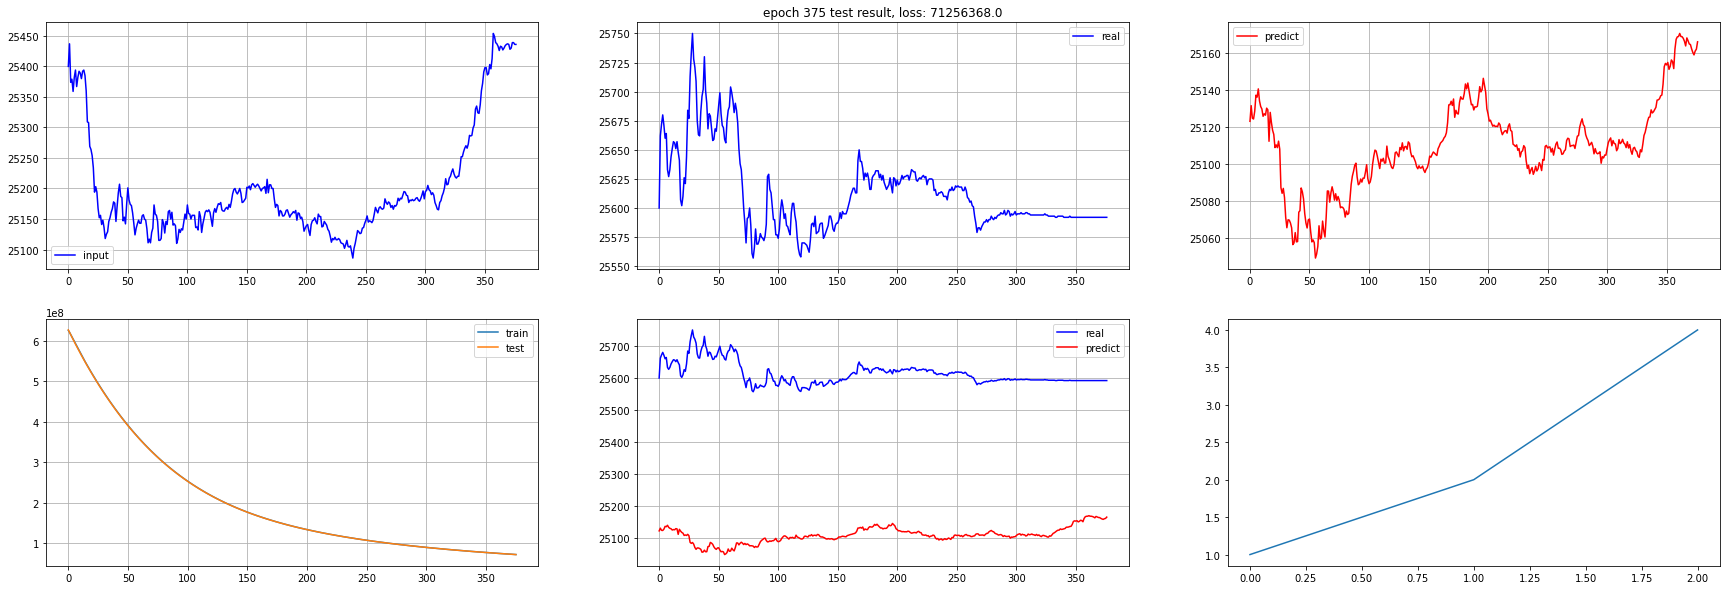

epoch 450 train: 59514816.0
epoch 450 test: 59488540.0


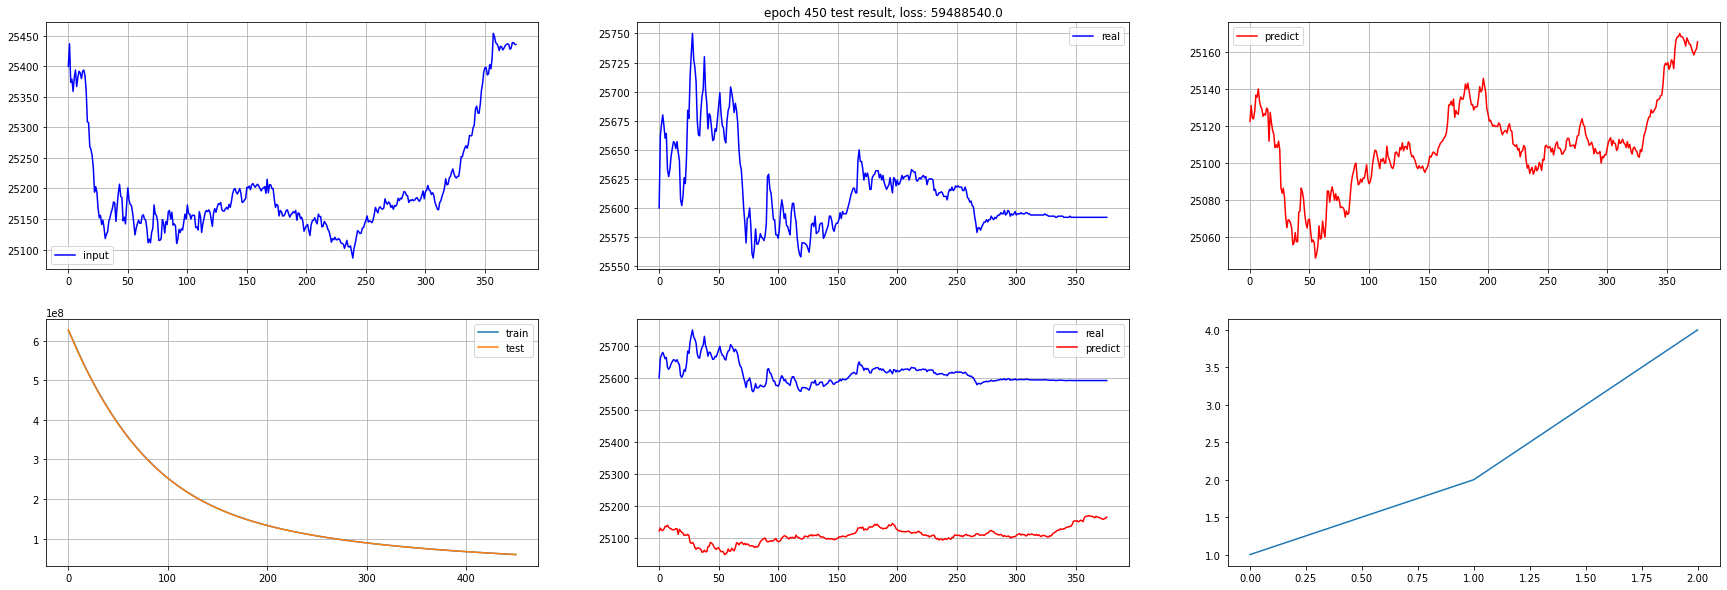

epoch 525 train: 51095884.0
epoch 525 test: 51076556.0


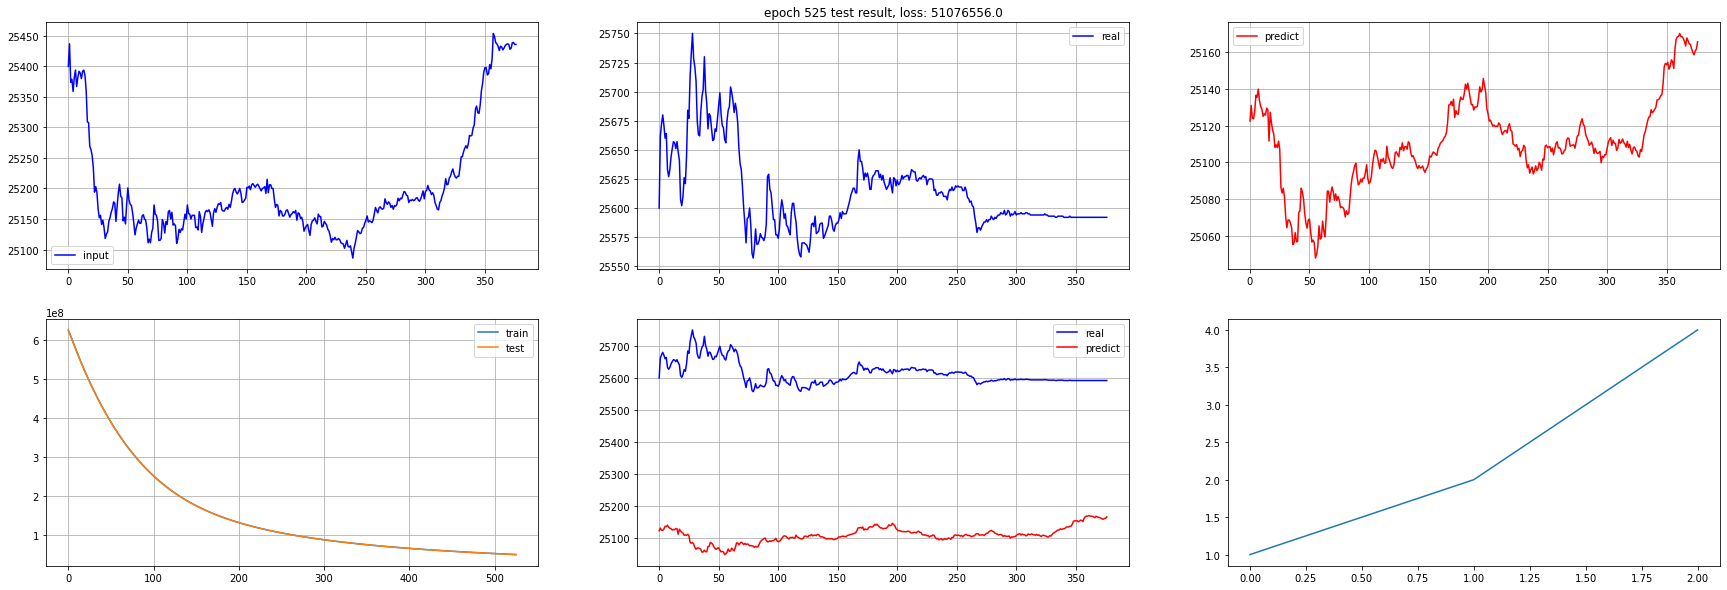

epoch 600 train: 44778880.0
epoch 600 test: 44764068.0


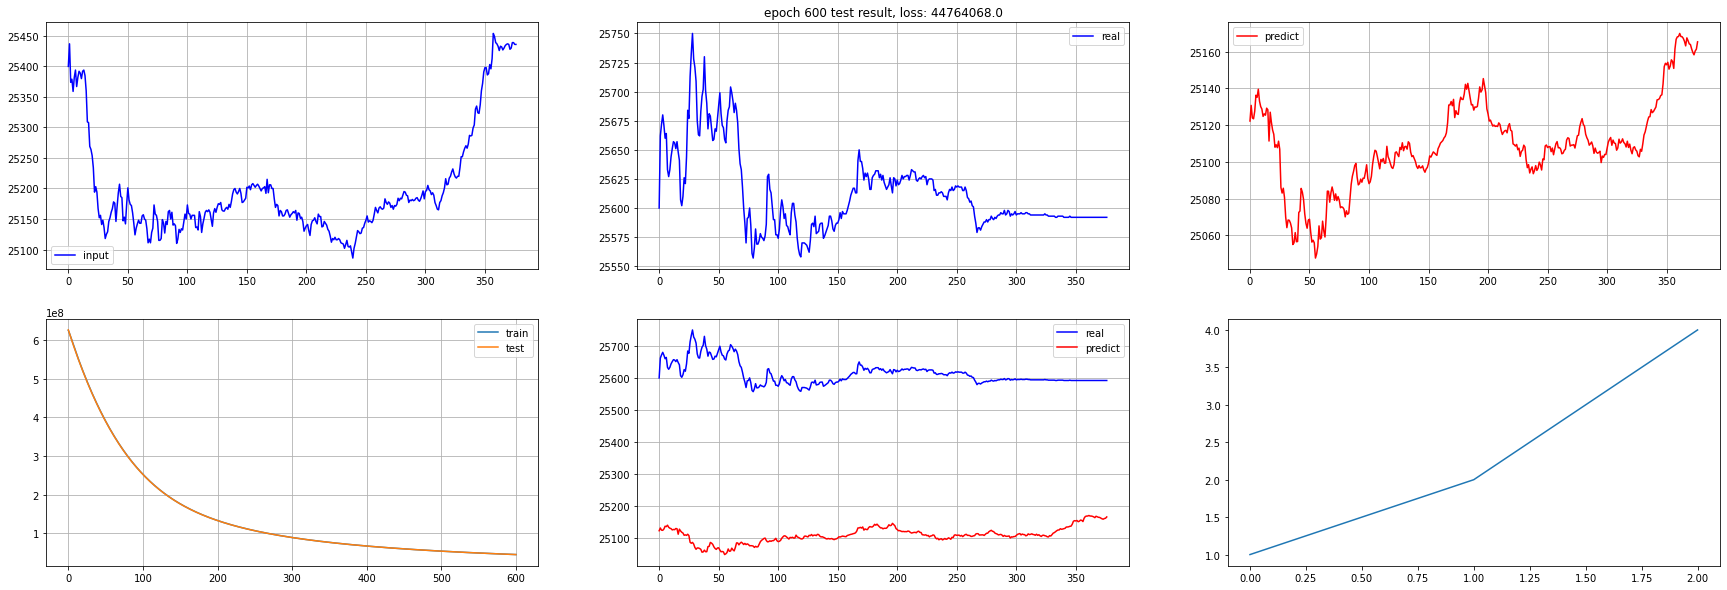

epoch 675 train: 39863996.0
epoch 675 test: 39852280.0


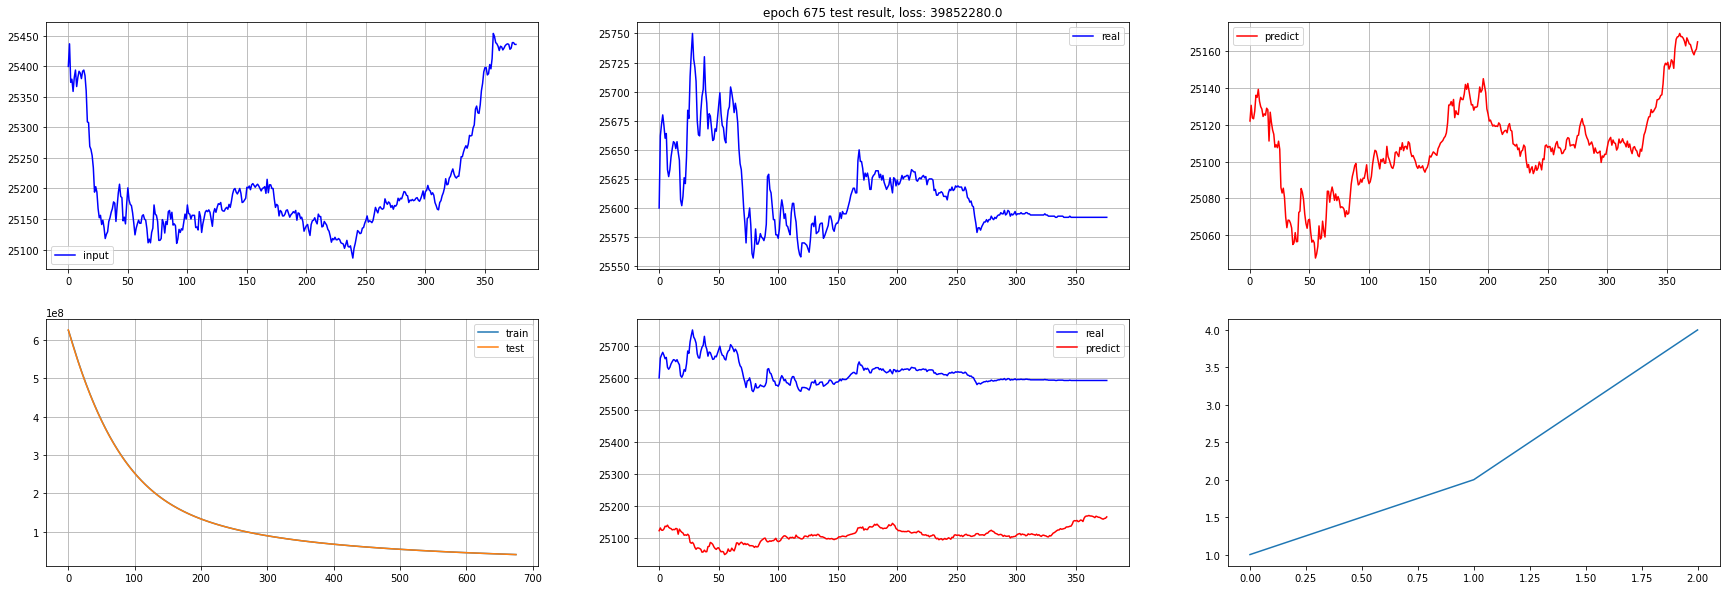

epoch 750 train: 35931040.0
epoch 750 test: 35921540.0


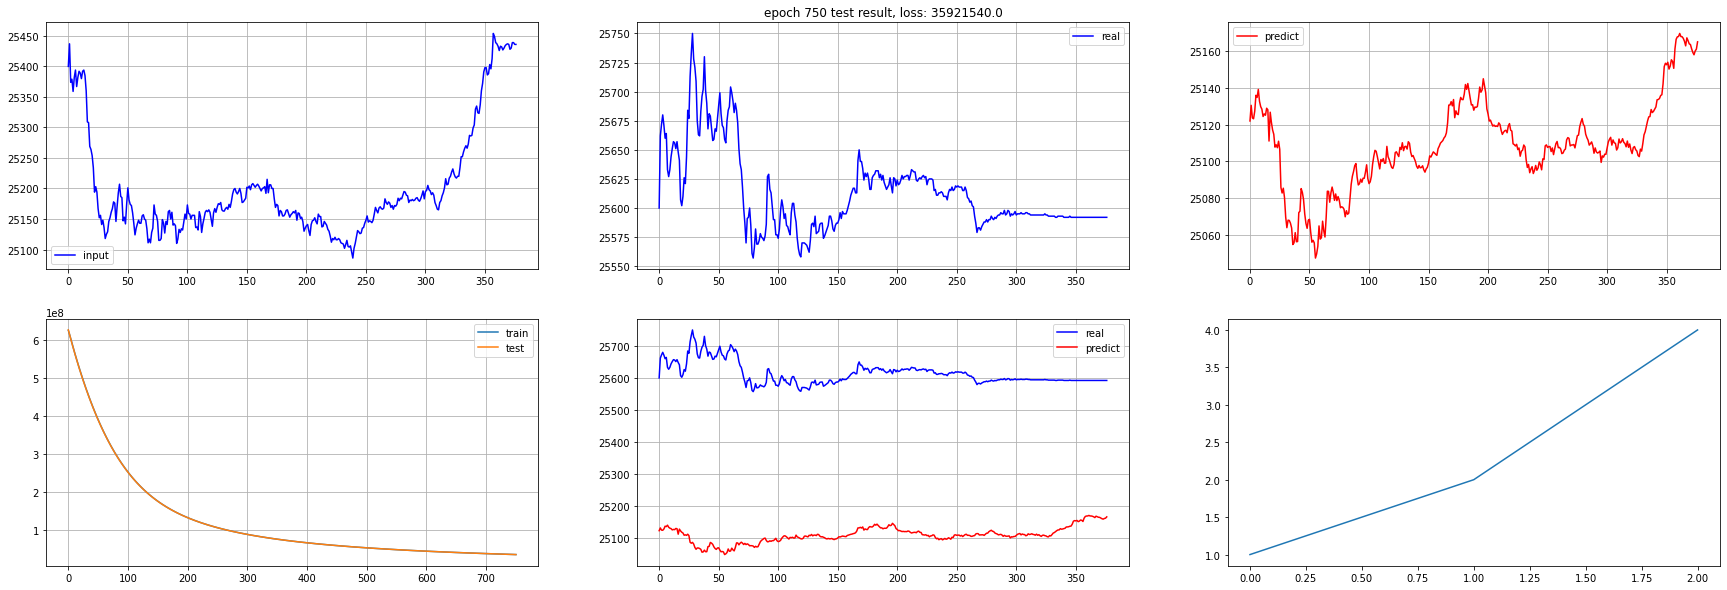

epoch 825 train: 32712474.0
epoch 825 test: 32704618.0


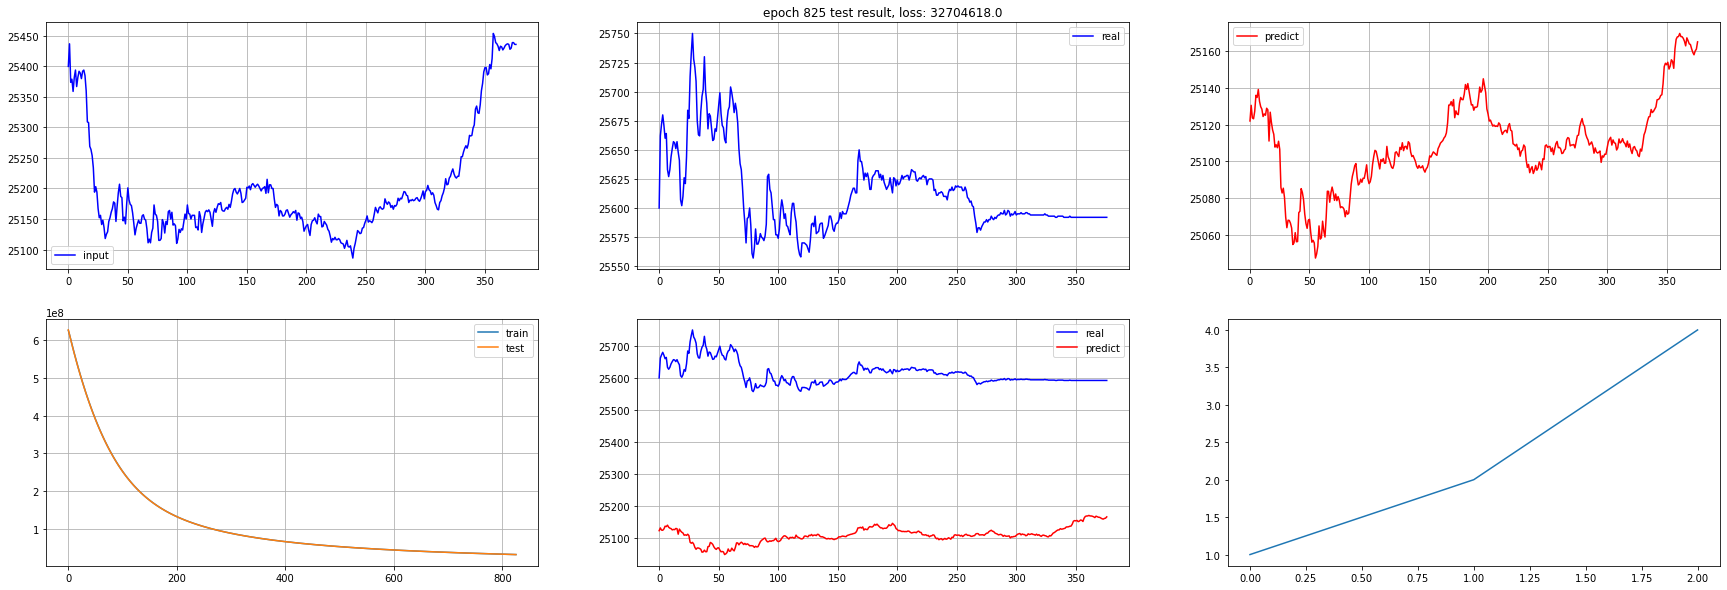

epoch 900 train: 30029860.0
epoch 900 test: 30023254.0


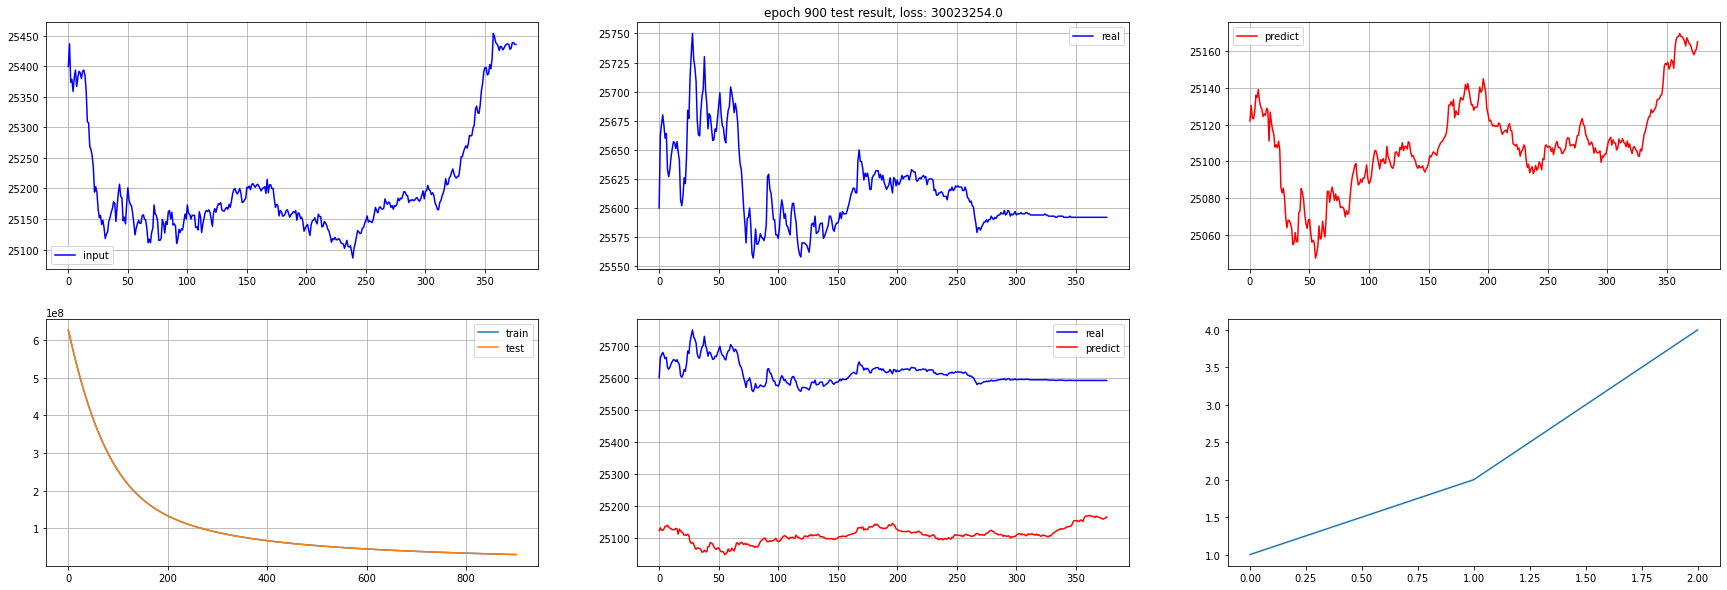

epoch 975 train: 27759618.0
epoch 975 test: 27753984.0


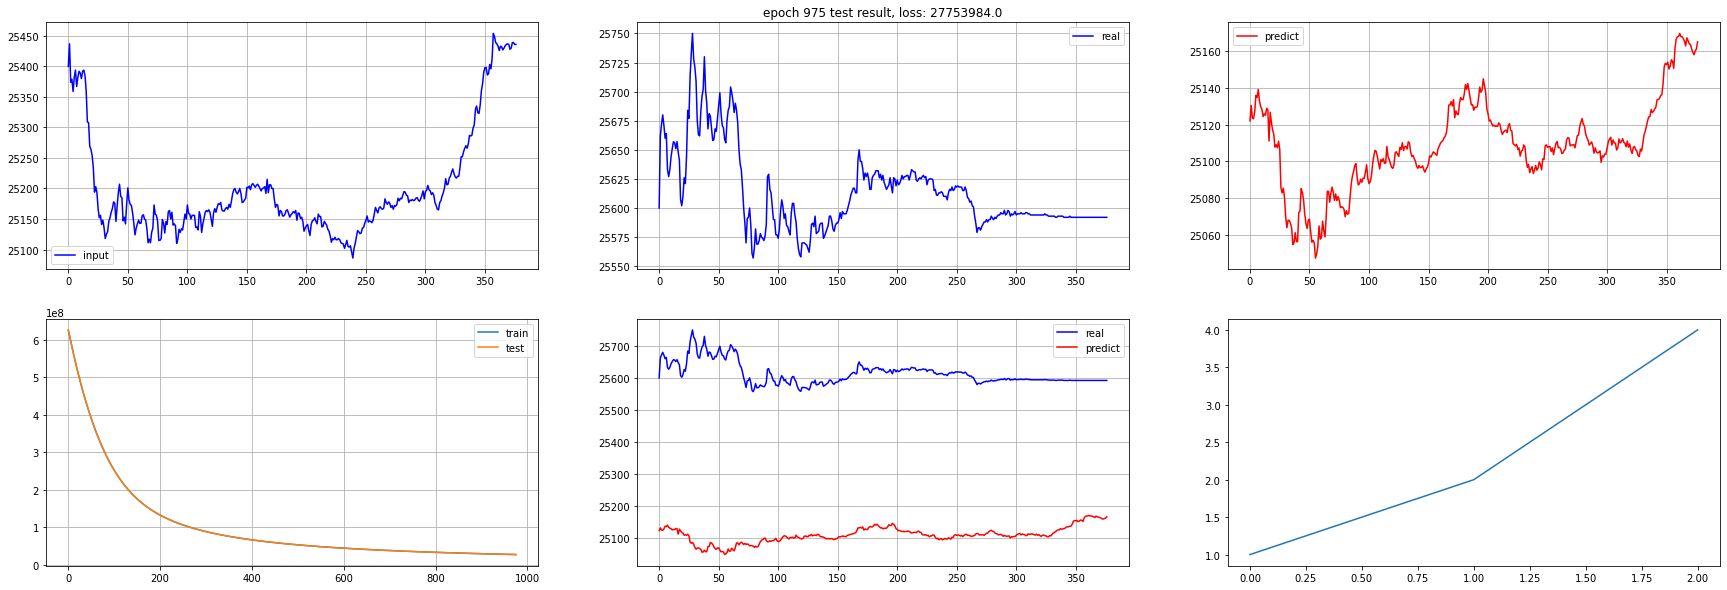

epoch 1050 train: 25813448.0
epoch 1050 test: 25808586.0


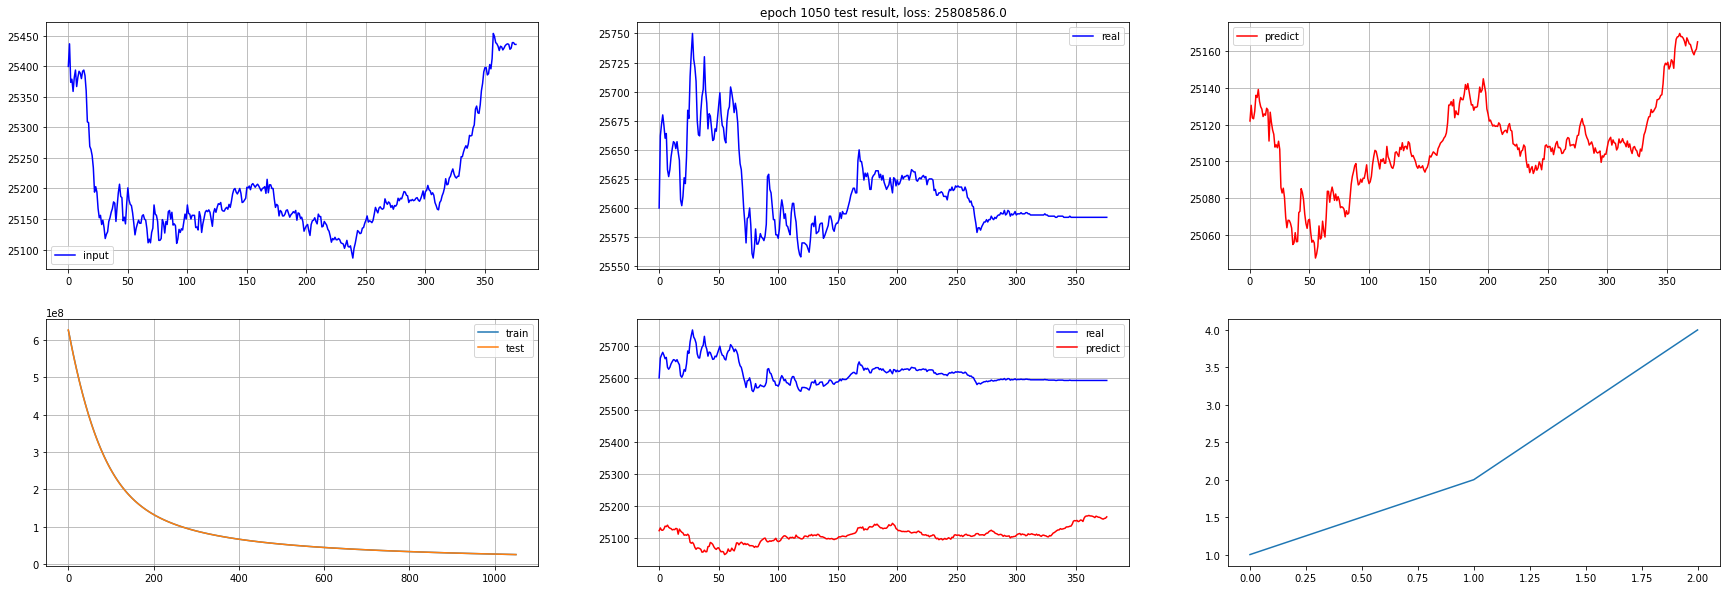

epoch 1125 train: 24126584.0
epoch 1125 test: 24122346.0


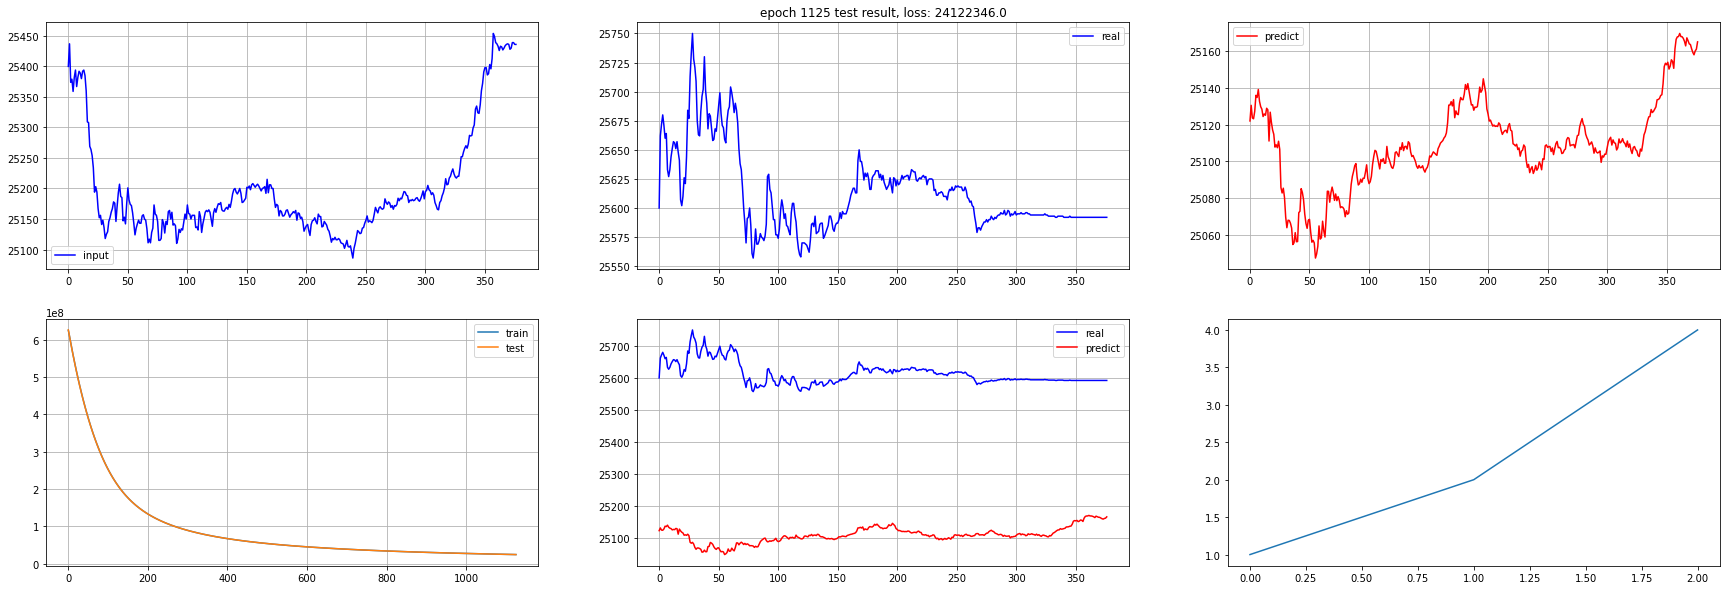

epoch 1200 train: 22650436.0
epoch 1200 test: 22646708.0


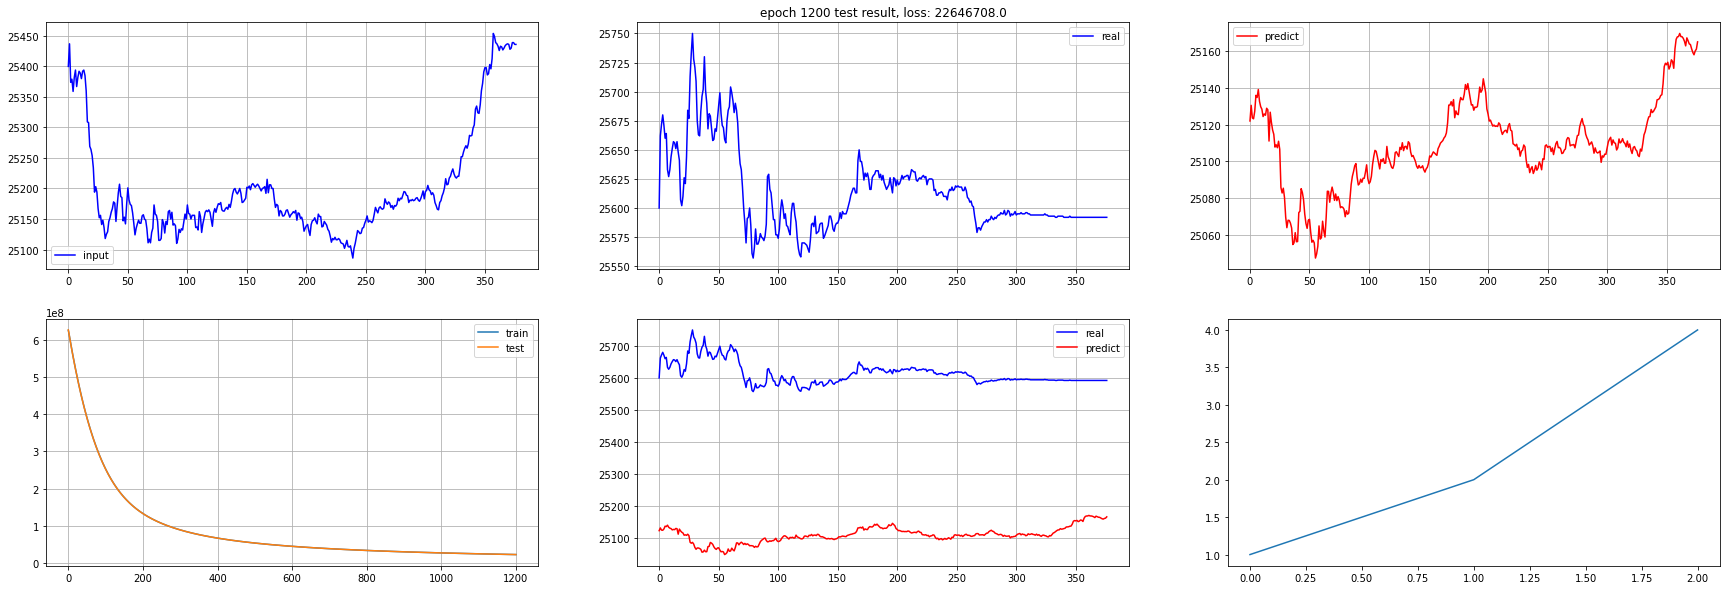

epoch 1275 train: 21347844.0
epoch 1275 test: 21344540.0


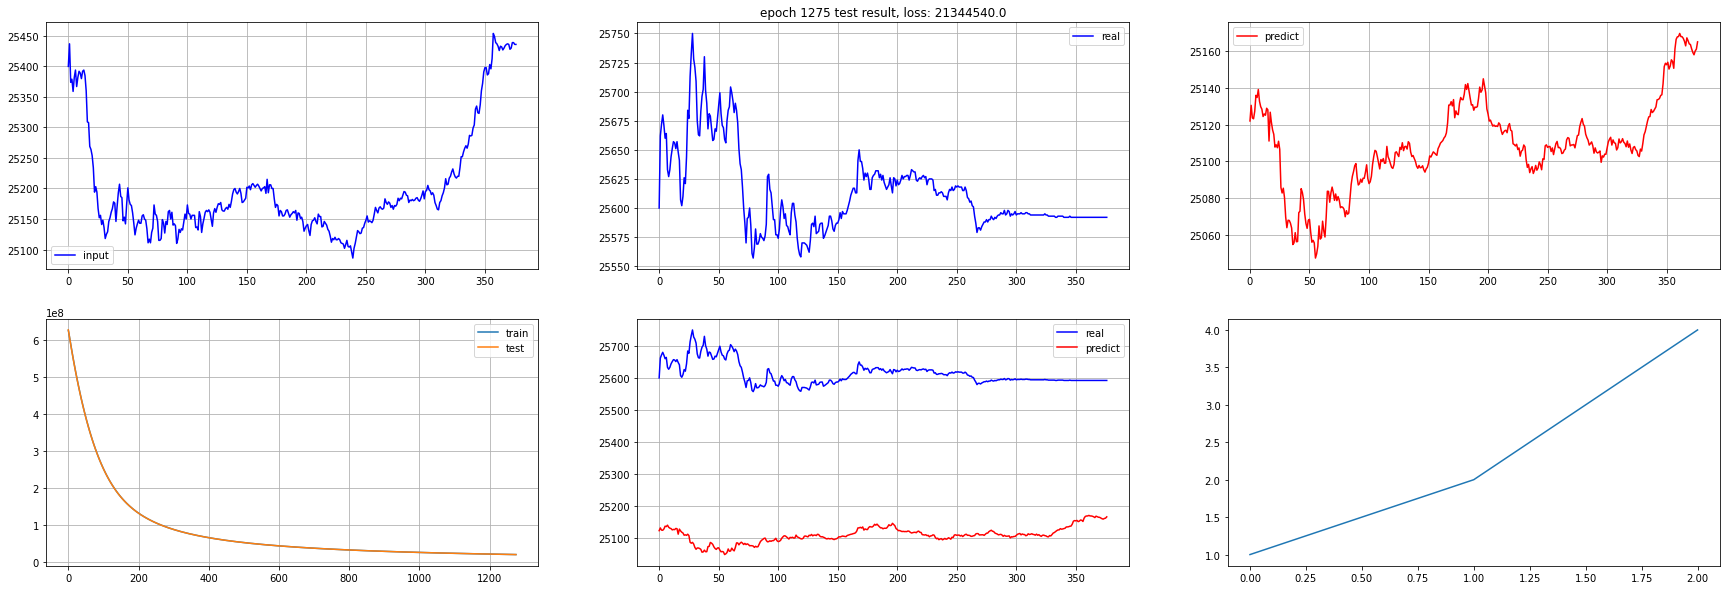

epoch 1350 train: 20189900.0
epoch 1350 test: 20186950.0


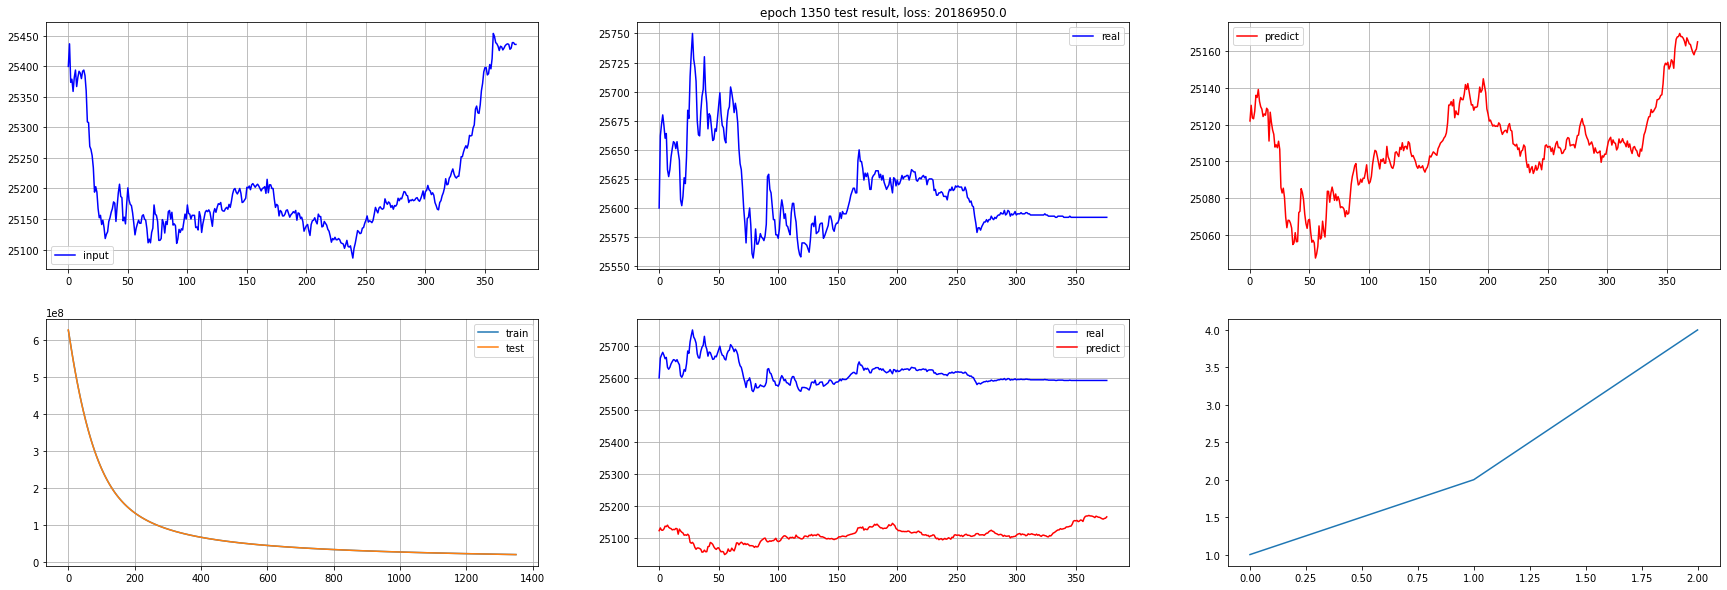

epoch 1425 train: 19153776.0
epoch 1425 test: 19151128.0


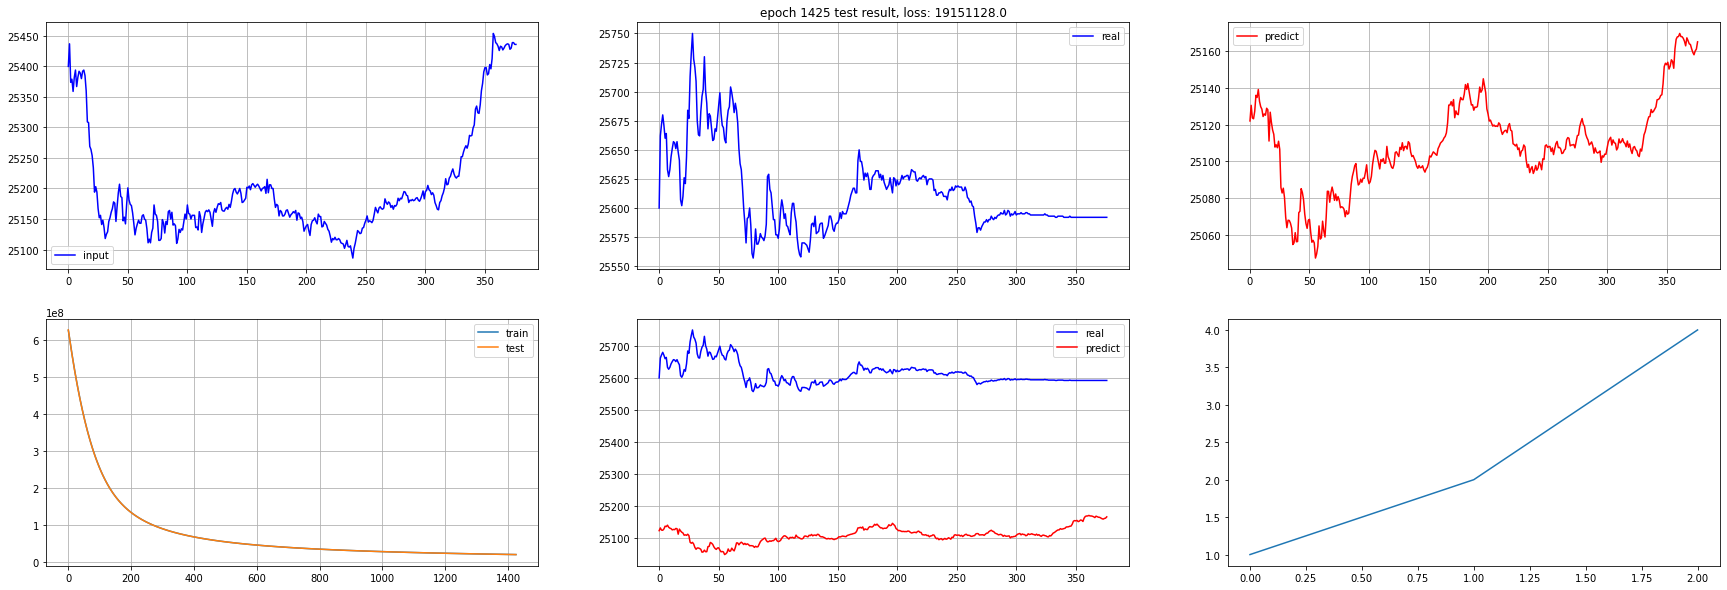

epoch 1500 train: 18221208.0
epoch 1500 test: 18218816.0


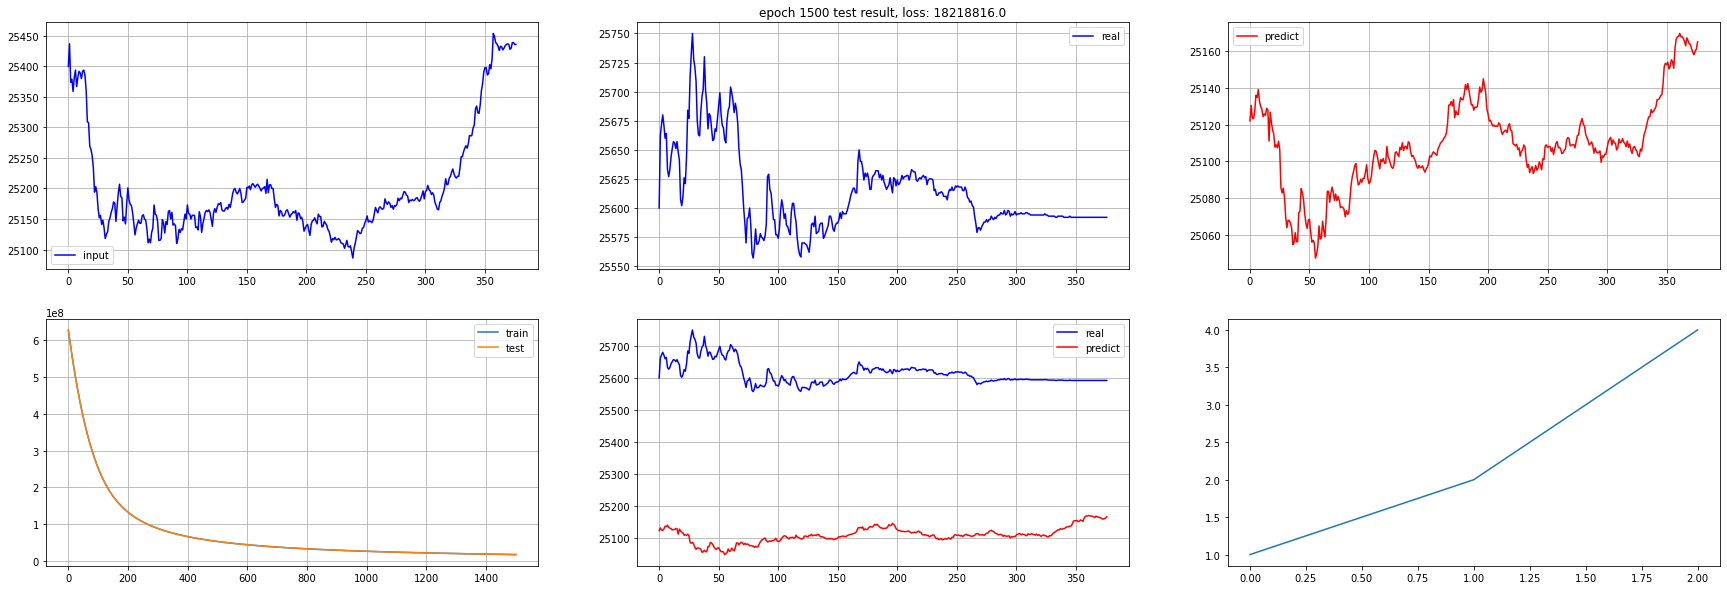

In [69]:
# parmas for training loop
n_epochs = 1500
run_params = {
    "batch_size": 1
}
record_period = 75

# loss function, optimiser and metrics 
loss_func = torch.nn.MSELoss().to(device)
optimiser = torch.optim.Adam(rnn.parameters(), lr=10)
metrics = torchmetrics.MeanSquaredError().to(device)

training_loss = []
testing_loss = []
for epoch in range(n_epochs+1): 
    # training
    for X, y in torch.utils.data.DataLoader(train, **run_params):
        # RNN here
        X, y = X.float().to(device), y.float().to(device)
        # y = y.squeeze(0)
        outputs = rnn(X)
        loss = loss_func(outputs.flatten(), y.flatten())
        loss.backward()
        optimiser.step()
        optimiser.zero_grad()
        metrics(outputs.flatten(), y.flatten())
    met = metrics.compute()
    training_loss.append(met)
    if epoch%record_period == 0: 
        print(f'epoch {epoch} train: {met}')

    # test
    for X, y in torch.utils.data.DataLoader(test, **run_params):
        # RNN here
        X, y = X.float().to(device), y.float().to(device)
        # y = y.squeeze(0)
        outputs = rnn(X)
        metrics(outputs.flatten(), y.flatten())
    met = metrics.compute()
    testing_loss.append(met)
    if epoch%record_period == 0: 
        print(f'epoch {epoch} test: {met}')

        X_input = torch.flatten(X.cpu().detach())
        X_pred = torch.flatten(outputs.cpu().detach())
        y = torch.flatten(y.cpu().detach())

        fig, [[ax1, ax2, ax3], [ax4, ax5, ax6]] = plt.subplots(nrows=2, ncols=3, figsize=(30, 10))
        ax1.plot(X_input, label="input", color="blue")
        ax1.legend()
        ax1.grid(True)
        ax2.plot(y, label="real", color="blue")
        ax2.legend()
        ax2.grid(True)
        ax2.set_title(f"epoch {epoch} test result, loss: {met}")
        ax3.plot(X_pred, label="predict", color="red")
        ax3.legend()
        ax3.grid(True)

        ax4.plot(training_loss, label="train")
        ax4.plot(testing_loss, label="test")
        ax4.legend()
        ax4.grid(True)

        ax5.plot(y, label="real", color="blue")
        ax5.plot(X_pred, label="predict", color="red")
        ax5.legend()
        ax5.grid(True)

        ax6.plot([1, 2, 4])

        plt.show()


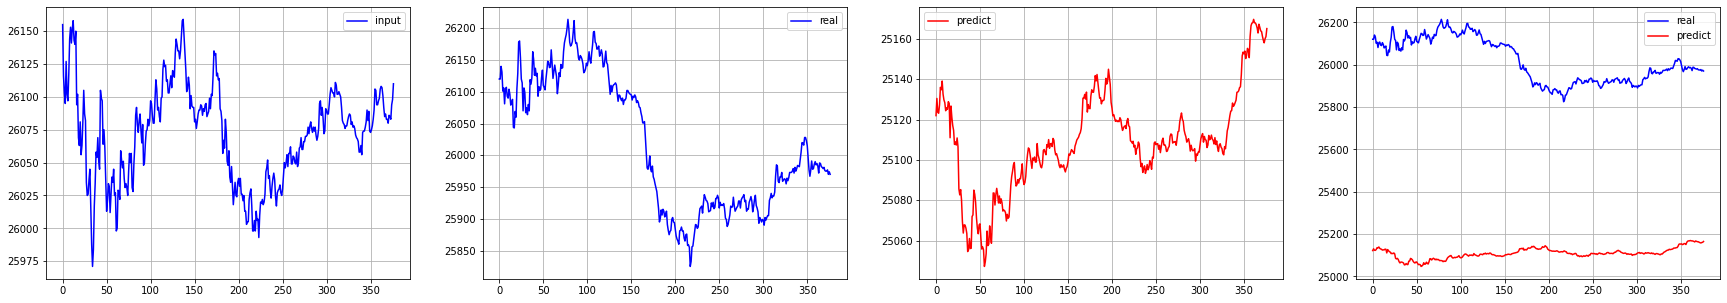

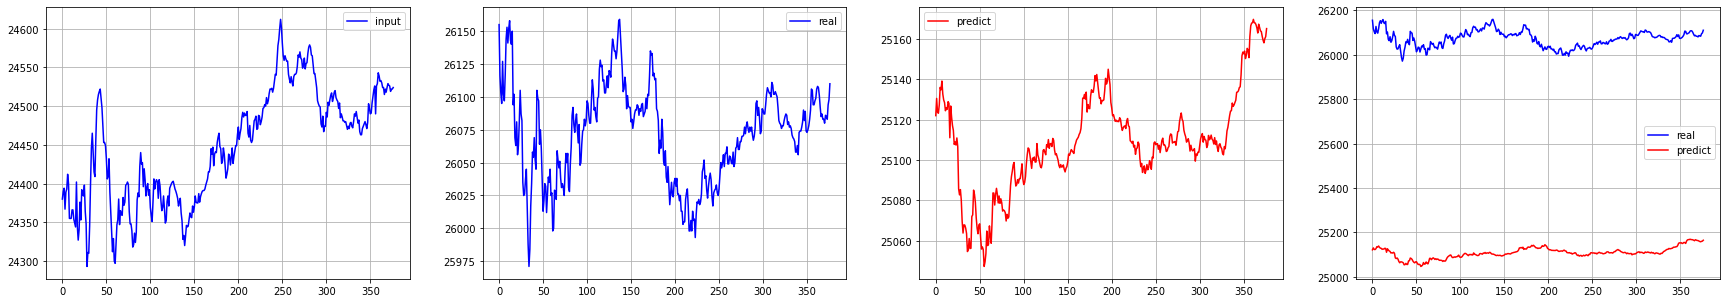

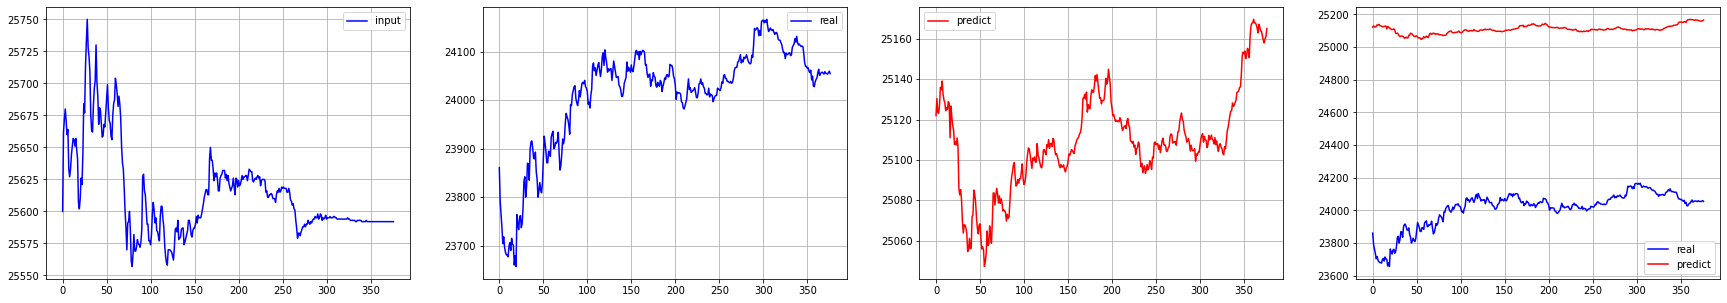

In [70]:
validation = torch.utils.data.DataLoader(val, **run_params)
for i, (X, y) in enumerate(validation): 
    X, y = X.float().to(device), y.float().to(device)
    output = rnn(X)

    X_input = torch.flatten(X.cpu().detach())
    X_pred = torch.flatten(outputs.cpu().detach())
    y = torch.flatten(y.cpu().detach())

    fig, [ax1, ax2, ax3, ax4] = plt.subplots(nrows=1, ncols=4, figsize=(30, 5))
    ax1.plot(X_input, label="input", color="blue")
    ax1.legend()
    ax1.grid(True)

    ax2.plot(y, label="real", color="blue")
    ax2.legend()
    ax2.grid(True)

    ax3.plot(X_pred, label="predict", color="red")
    ax3.legend()
    ax3.grid(True)

    ax4.plot(y, label="real", color="blue")
    ax4.plot(X_pred, label="predict", color="red")
    ax4.legend()
    ax4.grid(True)
    plt.show()